# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [ ]:
# utilidades
import math

# manejo de datos
import numpy as np
import pandas as pd

# visualización
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# tratamiento de texto
import spacy
import re

# visualización de progreso
from tqdm.auto import tqdm

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [ ]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [ ]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

El dataframe contiene 47331 entradas y 17 columnas correspondientes a:

· Identificador del título
· Tipo de título: Película, serie, corto, etc.
· Título principal
· Título original
· Año de inicio
· Año de término
· Duración en minutos
· Es para adultos
· Géneros
· Puntuación promedio
· Número de votos
· Reseña
· Puntuación
· Reseña negativa o positiva
· La reseña es positiva
· Pertenece al conjunto de prueba o entrenamiento
· Identificador de la reseña


Las columnas año de término y duración en minutos son tipo objeto, se pueden cambiar a entero.

A continuación se muestra el número de valores únicos de la columna 'end_year'.

In [ ]:
df_reviews['end_year'].value_counts().head()

\N      45052
2007      225
2008      190
2006      140
2009      130
Name: end_year, dtype: int64

Esta columna tiene 45052 valores ausentes, por lo cual se descarta para el presente análisis, pues no aporta mucha información.

In [ ]:
df_reviews = df_reviews.drop(columns=['end_year','sp'])

Se prosigue mostrando los valores únicos de la columna 'runtime_minutes'.

In [ ]:
df_reviews['runtime_minutes'].unique()

array(['121', '25', '88', '85', '90', '113', '96', '99', '43', '82', '74',
       '100', '95', '129', '60', '92', '98', '104', '94', '116', '102',
       '141', '89', '120', '180', '97', '107', '87', '44', '149', '130',
       '40', '45', '84', '30', '\\N', '70', '126', '110', '93', '80',
       '78', '8', '118', '123', '106', '79', '109', '112', '139', '117',
       '46', '135', '31', '12', '1', '72', '58', '77', '150', '7', '101',
       '91', '138', '10', '108', '105', '61', '69', '152', '47', '65',
       '23', '119', '374', '225', '66', '71', '15', '114', '83', '20',
       '301', '216', '148', '155', '251', '67', '177', '103', '62', '81',
       '111', '140', '125', '122', '124', '76', '146', '42', '50', '400',
       '73', '115', '75', '200', '22', '133', '160', '86', '21', '128',
       '230', '29', '162', '127', '147', '53', '13', '151', '9', '278',
       '179', '63', '137', '59', '165', '1140', '263', '54', '143', '183',
       '131', '51', '157', '132', '64', '57', '11', '4

In [ ]:
(df_reviews['runtime_minutes']=='\\N').sum()

488

In [ ]:
488/47331

0.01031036741247808

Existen 488 valores ausentes en esta columna que se han marcado como \\N, que representan el 1% de los valores. Debido a que proporcionalmente son pocos valores ausentes, podemos reemplazar este valor con la mediana.

In [ ]:
df_reviews[df_reviews['runtime_minutes']!='\\N']['runtime_minutes'].astype('int').median()

95.0

In [ ]:
df_reviews['runtime_minutes']= df_reviews['runtime_minutes'].replace('\\N', '95').astype('int')

Se muestran las estadísticas descriptivas de las columnas numéricas.

In [ ]:
df_reviews.describe()

,start_year,runtime_minutes,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,98.720965,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,38.126385,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,1.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,87.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,95.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,109.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1140.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


El año de inicio de los títulos reseñados va desde 1894 al 2010. La duración de los títulos va desde 1 minuto hasta 1140 minutos. con un promedio de 99 minutos. Menos del 0.01% de los títulos reseñados son para adultos. Las puntuaciones promedio por título van desde el 1.4 a 9.7 con un promedio aproximado de 6. El número de votos va de los 9 al 1,739,448.

Aproximadamente la mitad de las reseñas son positivas.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Buen trabajo con la carga de datos y la exploración inicial!
</div>

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

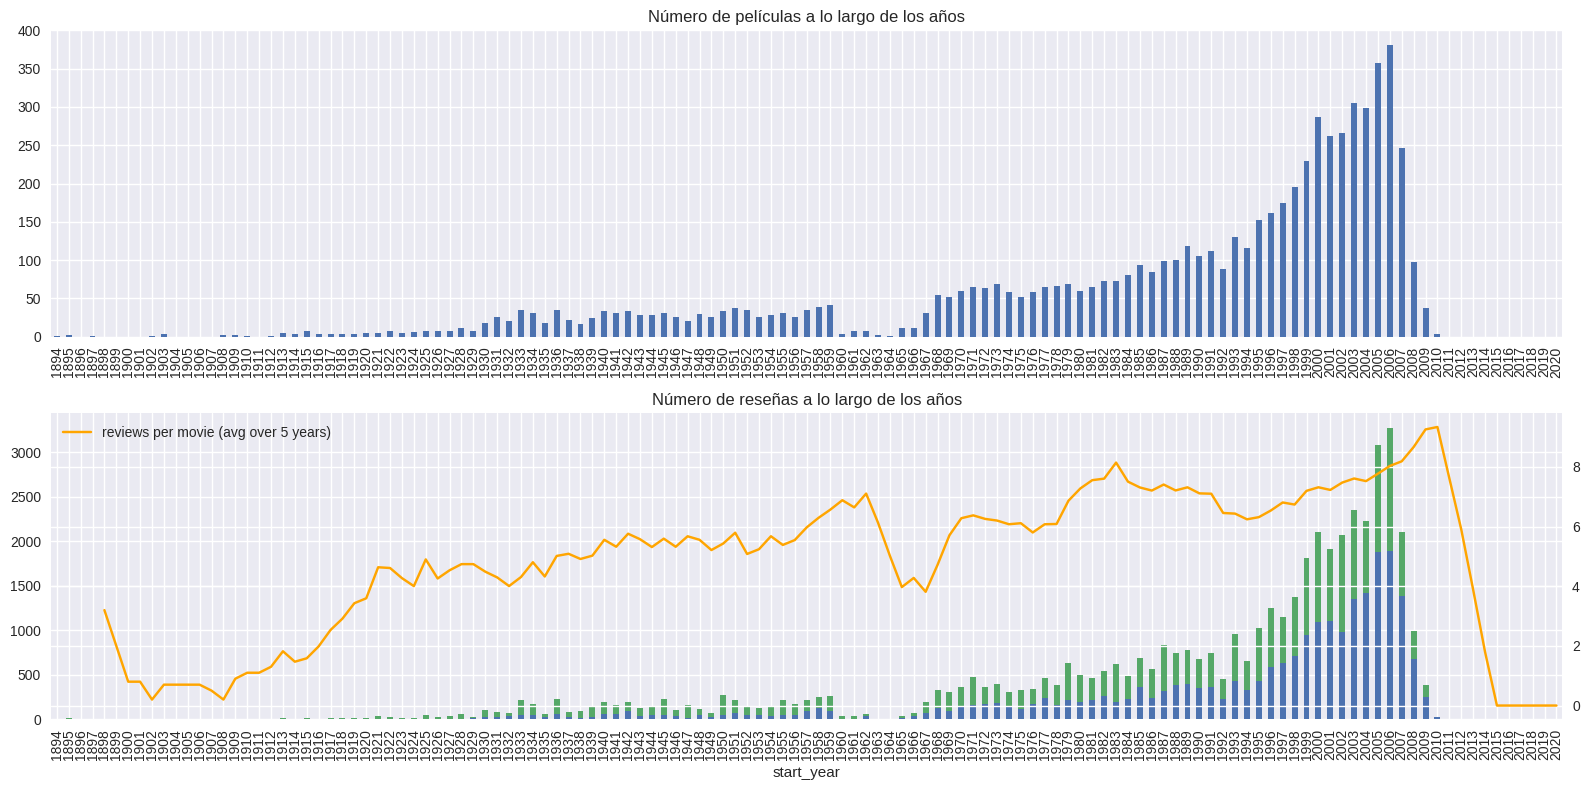

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Gráfico de número de películas reseñadas por año (arriba). Gráfico de número de reseñas positivas (azul), negativas (verde) y media rodante (amarillo). Se observa un aumento exponencial hasta el año 2007. El principio de la década de los 60 muestra un decremento significativo en el número de películas con reseñas.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

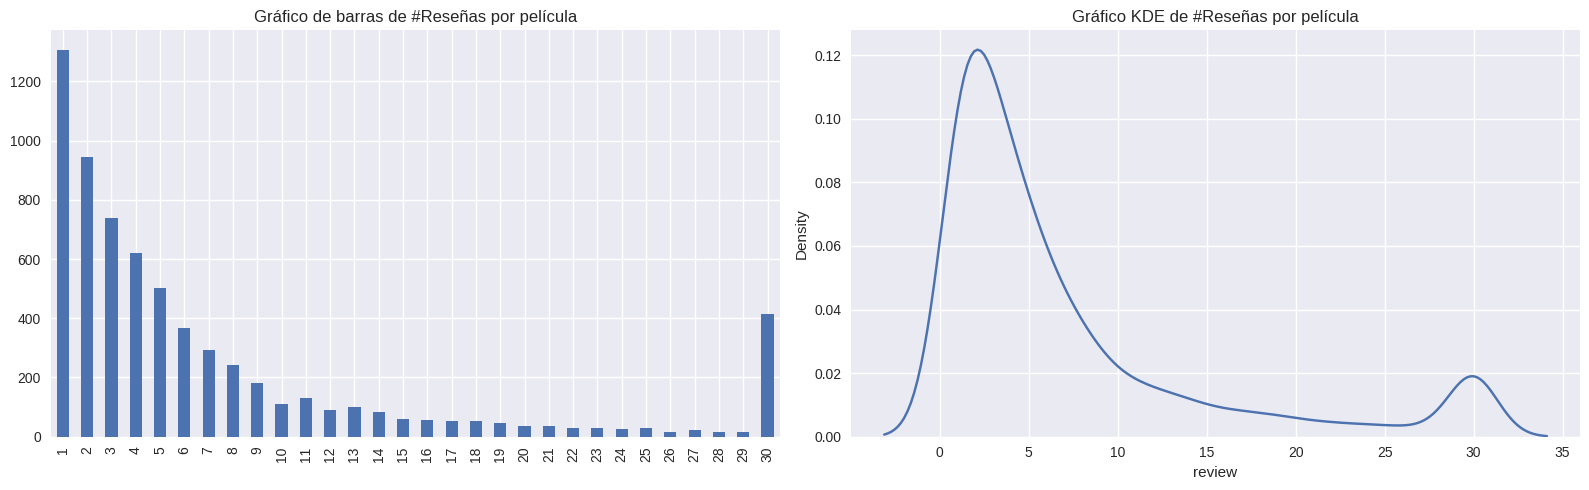

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Gráfico de número de reseñas por película a la izquierda y su distribución a la derecha. Parece ser que el dataset se eligió tomando en cuenta sólo películas con 30 reseñas o menos, por eso hay un máximo relativo en este valor.

Se puede notar que la mayoría de las películas tienen 1 reseña y este número decrece.

In [ ]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

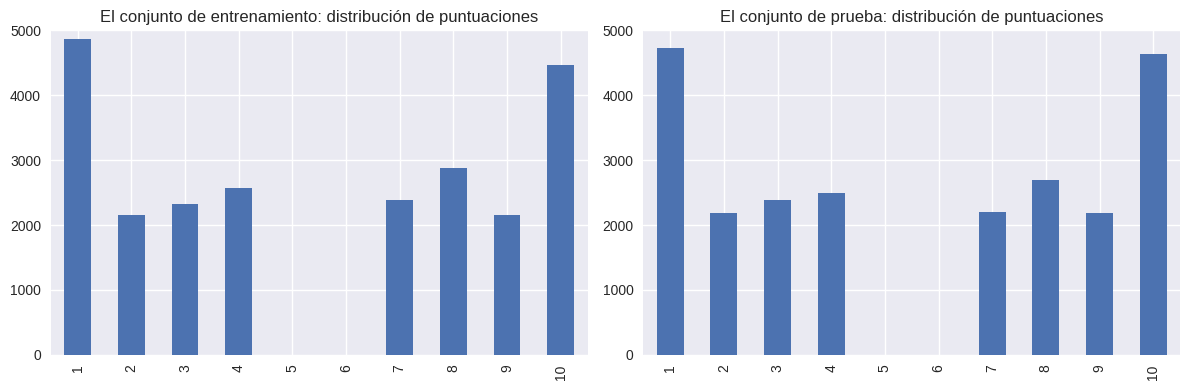

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de puntuaciones para el conjunto de entrenamiento (izquierda) y prueba (derecha). Se observa que el dataset está conformado por reseñas polarizadas, se excluyen reseñas ambigüas o neutrales. Ambos conjuntos exhiben la misma distribución, lo cual ayuda a que las predicciones entrenadas en el primer conjunto sean congruentes con el segundo.

Por otro lado, existe un desbalance de clases en ambos conjuntos: las calificaciones de 1 y 10 son más numerosas que el resto de las puntuaciones, esto podría deberse a cómo se seleccionó el conjunto o podría ser un reflejo de cómo las personas evalúan el medio. Sin embargo esto no representa un problema pues la característica objetivo está binarizada, y las clases positiva y negativa están balanceadas en ambos conjuntos.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


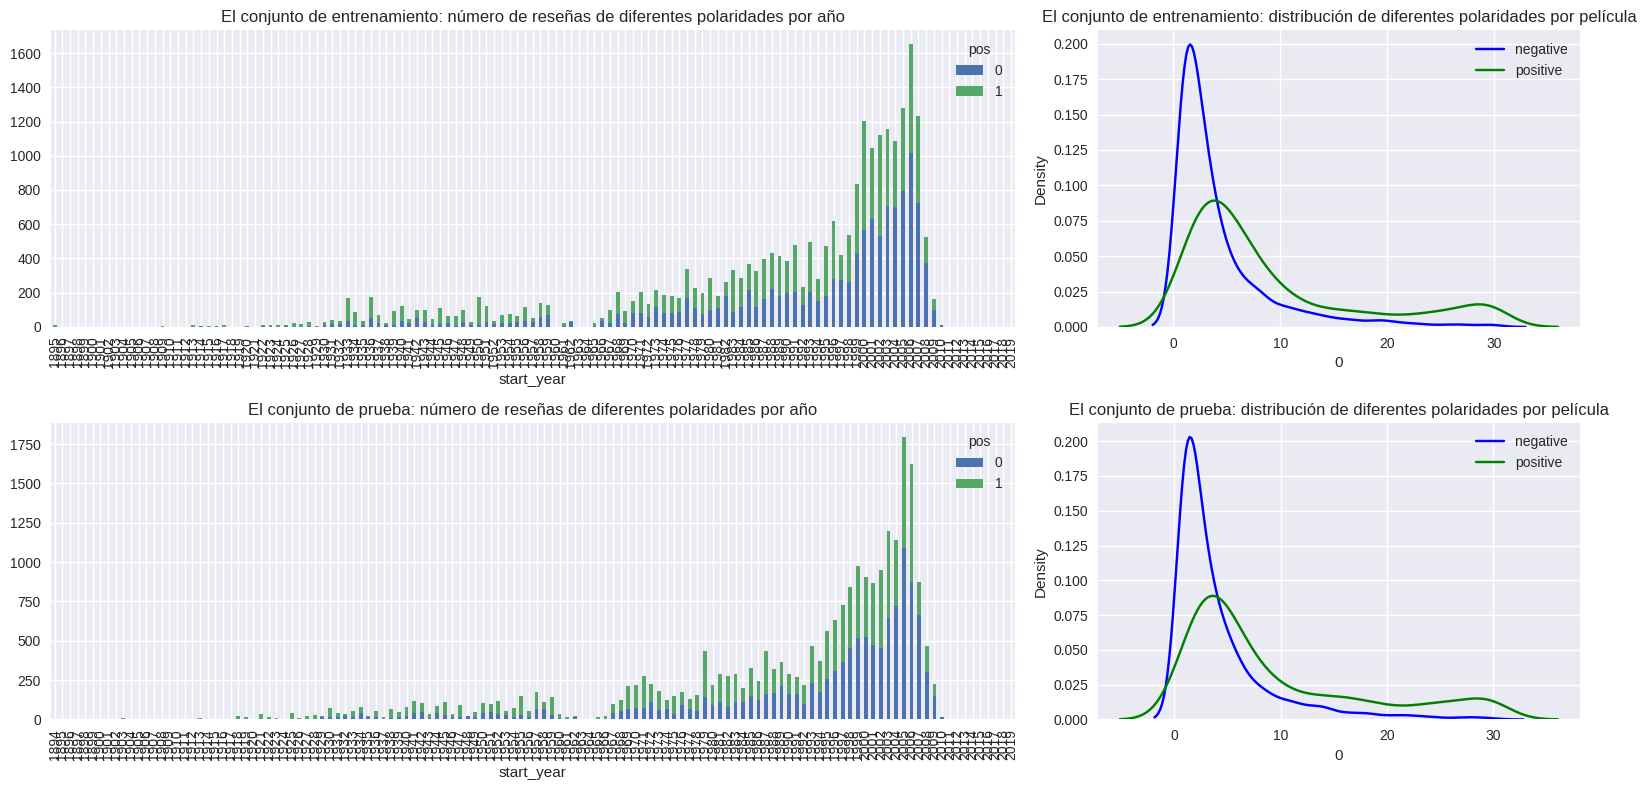

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Gráficos de número de reseñas positivas (verde) y negativas(azul) para cada año (izquierda), para el conjunto de entrenamiento (arriba) y prueba (abajo). Distribución de reseñas (derecha). Las distribuciones parecen ser congruentes en cada uno de los conjuntos.

<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto! Recuerda que el EDA es para entender mejor nuestros datos, por lo que te recomendaría redactar conclusiones un poco más detalladas y hacer un poco de referencia a como podría afectar a los modelos
</div>

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [ ]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

Se crea una función para encontrar expresiones regulares, pasarlas a minúsculas y volverlas a unir con un solo espacio.

In [ ]:
def text_norm(text, pattern):
    text = re.sub(pattern, " ", text).lower().split()
    text = " ".join(text)
    return text

Se crea una nueva columna con texto normalizado, se incluye la apóstrofe para la detección de expresiones regulares.

In [ ]:
df_reviews['review_norm'] = df_reviews['review'].apply(text_norm, pattern=r"[^a-zA-Z']")

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Perfecto! Realizaste un buen trabajo con la normalización y creando la función de evaluación
</div>

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 16)
(23535, 16)


En este trabajo nos interesa predecir si una reseña es favorable o no, exclusivamente a partir del texto, por lo cual sólo se tomará en cuenta la columna de reseñas normalizadas para posteriormente vectorizarla.

In [ ]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

## Trabajar con modelos

En este trabajo se evalúan tres clasificadores: Regresión Logística, Descenso de Gradiente y K Vecinos Cercanos. Para cada uno de estos modelos se exploran distintas estrategias para tokenizar y vectorizar los textos. La siguiente tabla resume los modelos a evaluar.

### Modelo 0 - Constante

Empezamos haciendo una prueba de cordura, que devuelve siempre la misma constante, en este caso 0. Dado que las clases positiva y negativa se encuentran balanceadas en ambos conjuntos, se espera que este modelo tenga una exactitud de 50%.

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
model_0 = DummyClassifier(strategy='constant', constant=0).fit(train_features, train_target)

           train  test
Exactitud    0.5   0.5
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


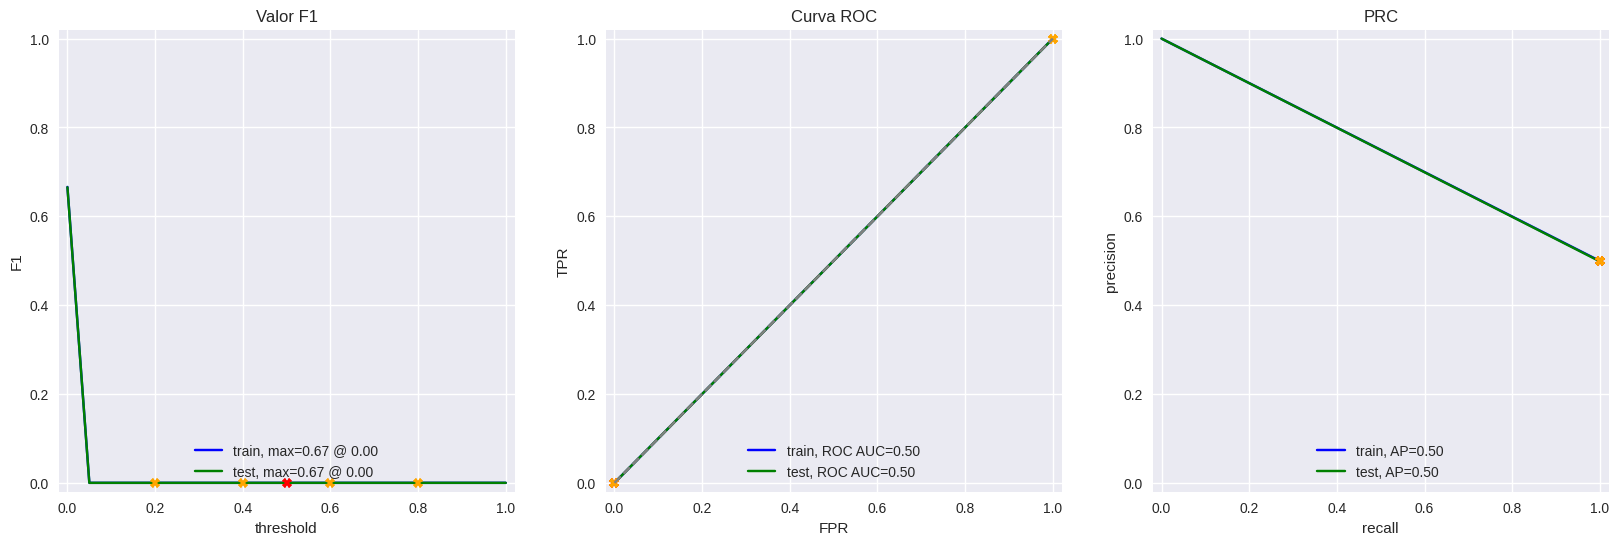

In [ ]:
evaluate_model(model_0, train_features, train_target, test_features, test_target)

Gráficos de valor F1, Curva ROC y PRC. Se observa que para umbrales mayores a 0.1, el score f1 se desploma. La exactitud del modelo es del 50%, lo cual tiene sentido dado el balance de clases.

### Modelo 1 - NLTK, TF-IDF y LR

El primer modelo toma palabras vacías de la librería Natural Language Toolkit, posteriormente transforma el texto a un vector con valores TF-IDF. Posteriormente se entrena el modelo de regresión logística.

In [ ]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

Se definen las palabras vacías, se empieza una bolsa de palabras y se transforma a TF-IDF.

In [ ]:
stop_words_nltk = set(nltk.corpus.stopwords.words('english'))

count_tf_idf =  TfidfVectorizer(stop_words=stop_words_nltk)

Se transforma el texto a vectores TF-IDF.

In [ ]:
train_features_1 = count_tf_idf.fit_transform(train_features)

test_features_1 = count_tf_idf.transform(test_features)

Se selecciona y entrena el modelo de regresión logística.

In [ ]:
model_1 = LogisticRegression(random_state=12345).fit(train_features_1, train_target)

Se evalúa el modelo.

           train  test
Exactitud   0.94  0.88
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


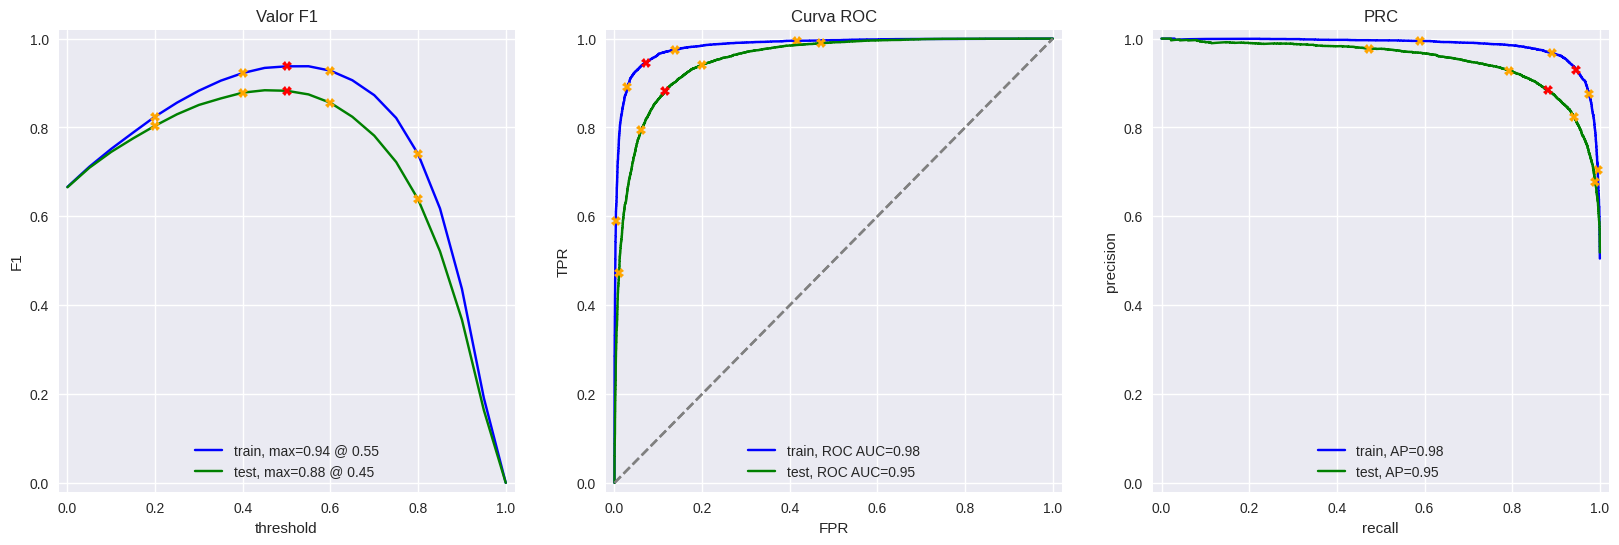

In [ ]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

A la izquierda gráfica de valor F1 contra umbral, al centro las curvas ROC para el conjunto de entrenamiento y prueba. A la derecha curva PRC para el conjunto de entrenamiento y de prueba.

Se observan mejoras significativas en todas las métricas respecto al modelo dummy. Las métricas en el modelo de prueba son menores que en el modelo de entrenamiento, lo cual indica un ligero sobreajuste.

### Modelo 3 - spaCy, TF-IDF y LR

Para el siguiente modelo se utiliza la librería Spacy para encontrar las palabras vacías y lematizar el texto. Posteriormente se repiten los mismos pasos que en el modelo anterior.

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Se establecen las palabras vacías de la librería spacy y se inicia una nueva bolsa de palabras.

In [ ]:
stop_words_2 = spacy.lang.en.stop_words.STOP_WORDS

count_tf_idf_2 =  TfidfVectorizer(stop_words=stop_words_2)

Se crea otra función para lematizar el texto.

In [ ]:
def lemmatize(text):

    doc = nlp(text.replace(r'[\']', ''))
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return ' '.join(tokens)

In [ ]:
df_reviews_train['lemmatized'] = df_reviews_train['review_norm'].apply(lemmatize)

df_reviews_test['lemmatized'] = df_reviews_test['review_norm'].apply(lemmatize)

In [ ]:
train_features_2 = count_tf_idf_2.fit_transform(df_reviews_train['lemmatized'])

test_features_2 = count_tf_idf_2.transform(df_reviews_test['lemmatized'])

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Se entrena el modelo de Regresión logística con el nuevo conjunto.

In [ ]:
model_2 = LogisticRegression(random_state=12345).fit(train_features_2, train_target)

           train  test
Exactitud   0.93  0.87
F1          0.93  0.87
APS         0.98  0.94
ROC AUC     0.98  0.95


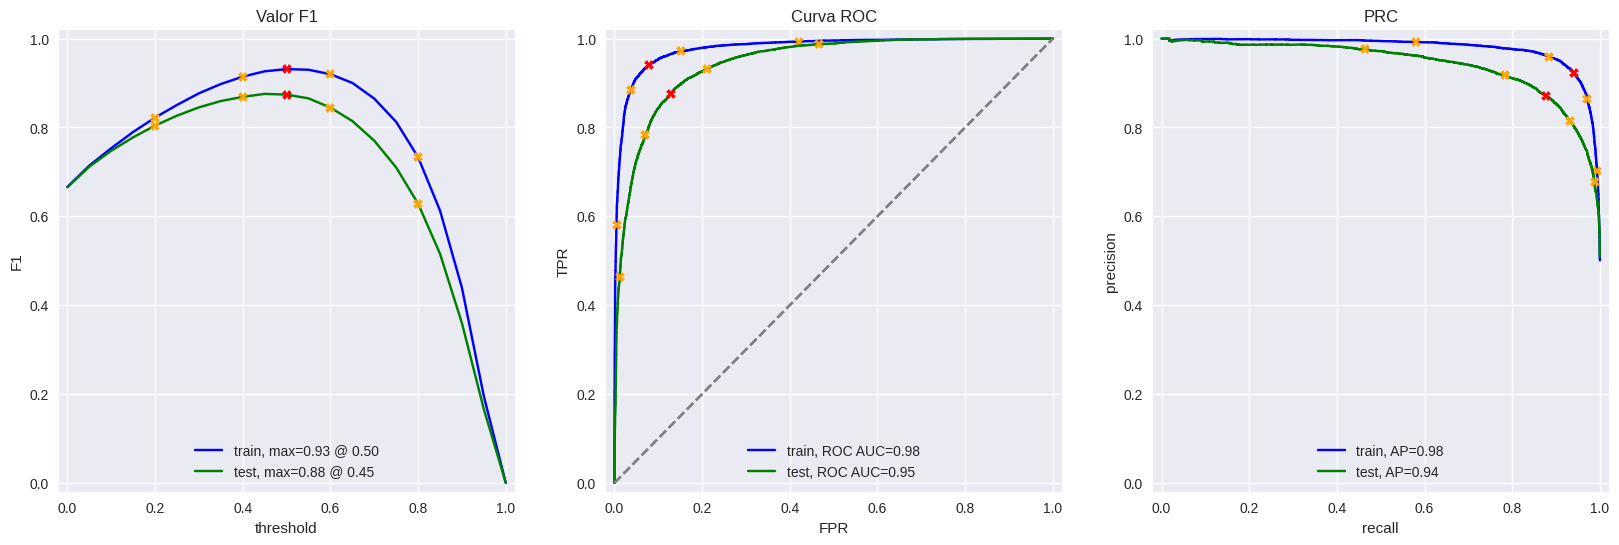

In [ ]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

A la izquierda gráfica de valor F1 contra umbral, al centro las curvas ROC para el conjunto de entrenamiento y prueba. A la derecha curva PRC para el conjunto de entrenamiento y de prueba.

Se obtienen resultados muy similares al modelo anterior, lo cual podría indicar que el proceso de lematización no mejora o emperoa significativamente la predicción en este contexto.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

En este modelo se utiliza el texto lematizado y vectorizado para un modelo de descenso de gradiente.

In [ ]:
from lightgbm import Dataset, LGBMClassifier

from sklearn.model_selection import GridSearchCV

Se establecen los parámetros del modelo por defecto.

In [ ]:
model_3 = LGBMClassifier(objective='binary').fit(train_features_2 , train_target)

           train  test
Exactitud   0.91  0.85
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.93


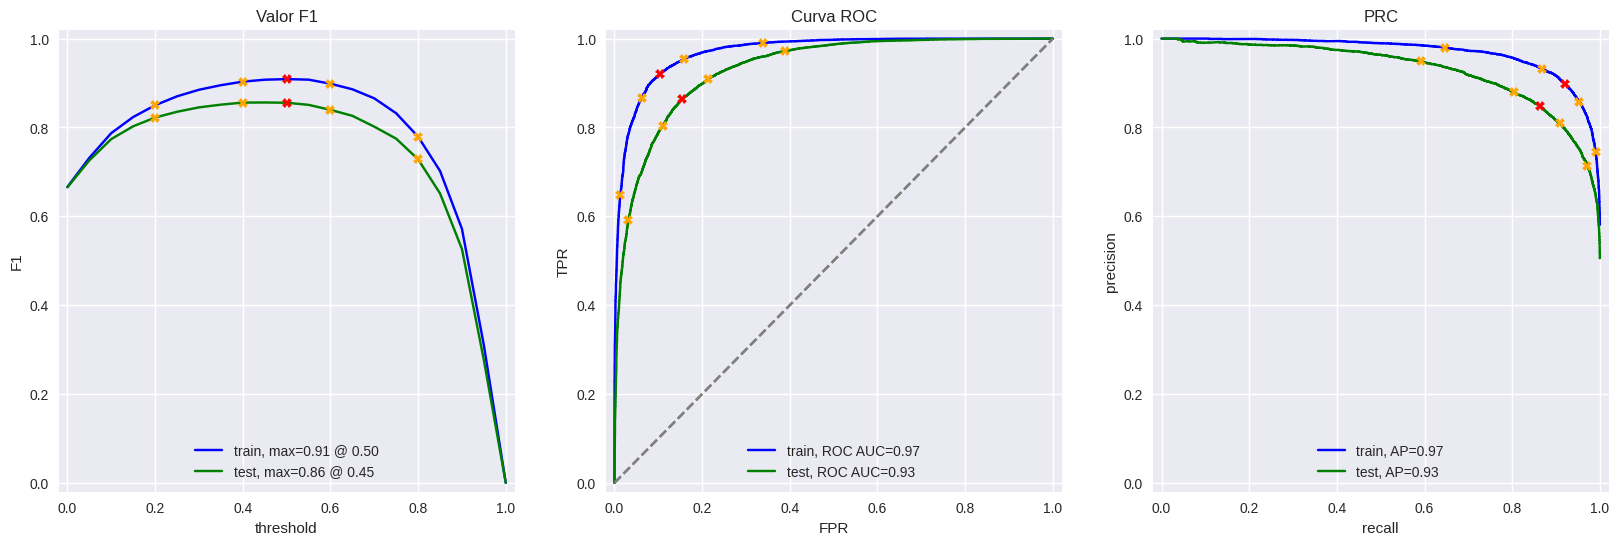

In [ ]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

A la izquierda gráfica de valor F1 contra umbral, al centro las curvas ROC para el conjunto de entrenamiento y prueba. A la derecha curva PRC para el conjunto de entrenamiento y de prueba.

La exactitud es más baja comparado con la clasificación por Regresión Logística, sin embargo se utilizaron los hiperparámetros por defecto. Tal vez se puedan obtener mejores resultados ajustando los hiperparámetros.

### Modelo 4 - NLTK, TF-IDF y LGBMClassifier

Ahora intentamos el mismo modelo con el conjunto 1.

In [ ]:
model_4 = LGBMClassifier(objective='binary').fit(train_features_1 , train_target)

           train  test
Exactitud   0.91  0.86
F1          0.92  0.86
APS         0.97  0.93
ROC AUC     0.97  0.94


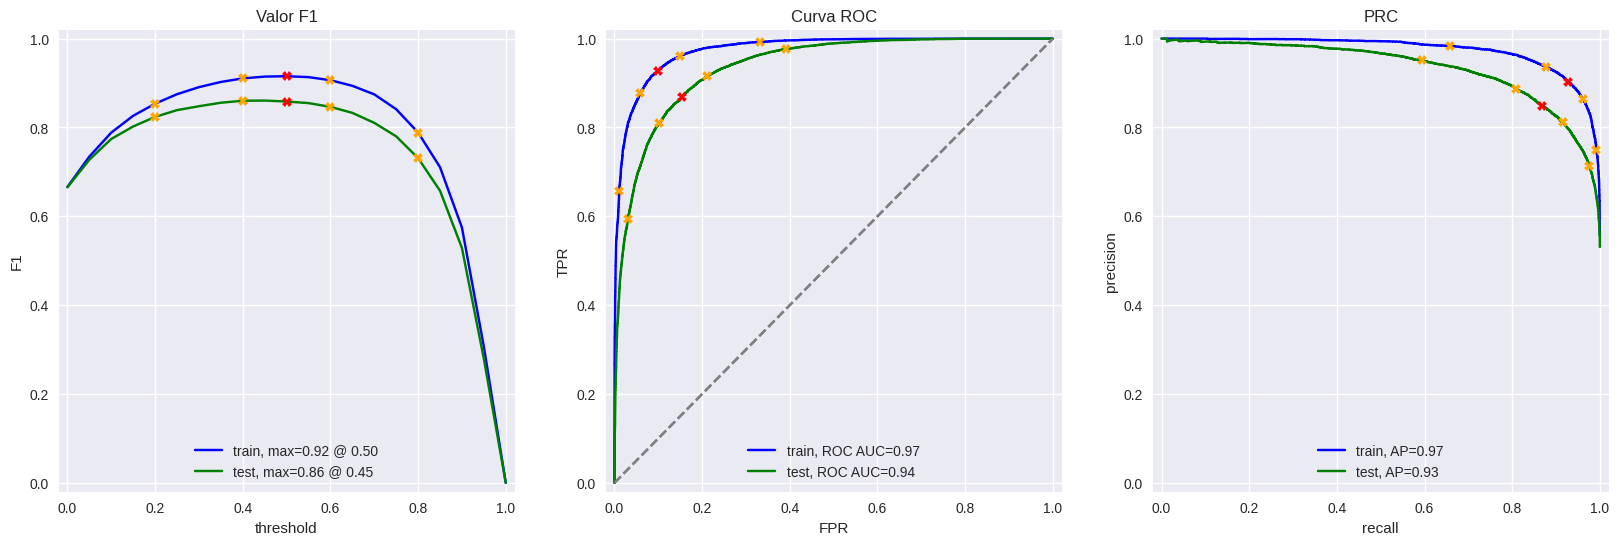

In [ ]:
evaluate_model(model_4, train_features_1, train_target, test_features_1, test_target)

A la izquierda gráfica de valor F1 contra umbral, al centro las curvas ROC para el conjunto de entrenamiento y prueba. A la derecha curva PRC para el conjunto de entrenamiento y de prueba.

La exactitud es más baja comparado con la clasificación por Regresión Logística, sin embargo se utilizaron los hiperparámetros por defecto. Tal vez se puedan obtener mejores resultados ajustando los hiperparámetros. El modelo mejora un poco son la librería NLTK.

### Modelo 5 - NLTK, TF-IDF y KNeighborsClassifier

Se emplea el modelo K vecinos cercanos.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Primero aplicaremos la herramienta GridSearch para encontrar el número óptimo de vecinos cercanos.

In [ ]:
model_5 = KNeighborsClassifier()

nei_search = GridSearchCV(model_5, {'n_neighbors': range(50, 251,10)}, scoring='f1', refit=True).fit(train_features_1, train_target)

print(nei_search.best_params_, nei_search.best_score_)

{'n_neighbors': 240} 0.7858216248347825


<AxesSubplot:xlabel='param_n_neighbors', ylabel='mean_test_score'>

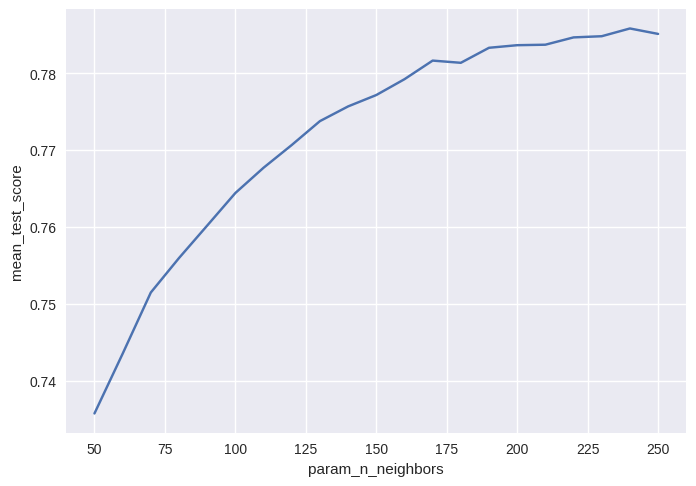

In [ ]:
knei_results = pd.DataFrame(nei_search.cv_results_)

sns.lineplot(data=knei_results, x='param_n_neighbors', y='mean_test_score')

Gráfico de score f1 en función de número de vecinos cercanos. Se observa que a partir de 200 vecinos cercanos el modelo no mejora significativamente. Una vez hecho esto se evalúa el modelo con los mejores parámetros.

In [ ]:
model_5 = KNeighborsClassifier(n_neighbors=240).fit(train_features_1, train_target)

           train  test
Exactitud   0.83  0.81
F1          0.83  0.80
APS         0.90  0.89
ROC AUC     0.91  0.90


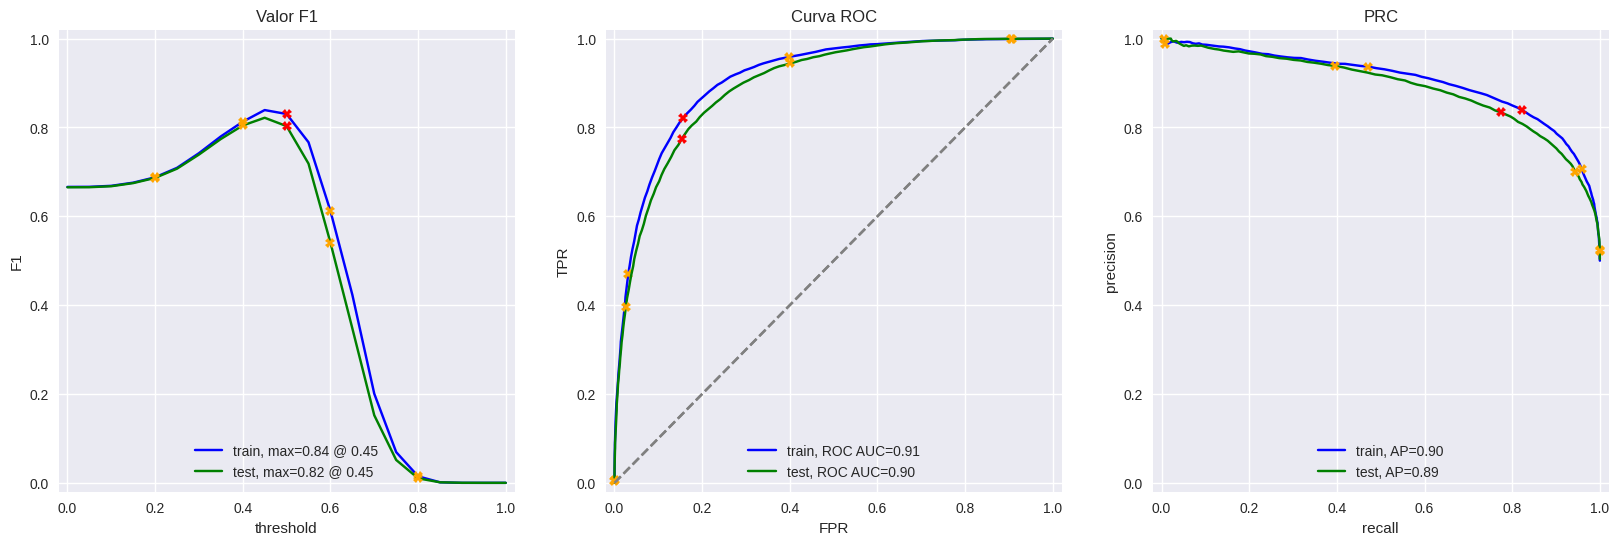

In [ ]:
evaluate_model(model_5, train_features_1, train_target, test_features_1, test_target)

A la izquierda gráfica de valor F1 contra umbral, al centro las curvas ROC para el conjunto de entrenamiento y prueba. A la derecha curva PRC para el conjunto de entrenamiento y de prueba.

La curva de score f1 contra umbral es diferente respecto a los demás modelos, en particular se observa que el score f1 disminuye drásticamente al aumentar el ubmral.

La exactitud del modelo es menor que los modelos anteriores sin embargo la diferencia de métricas entre los conjuntos de entrenamiento y prueba es mucho menor, lo cual indica mayor consistencia en los resultados y poco sobreajuste.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Excelente! Entrenaste diferentes modelos y se obtuvieron métricas bastante buenas
</div>

###  Modelo 6 - BERT

Para este modelo se utiliza la tokenización y se obtienen insertados BERT. Una vez descargados los insertados se procede a entrenar un modelo de regresión logística, debido a que fue el que mejores resultados presentó.

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención

    for text in texts:
        ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=max_length)

        padded = np.array(ids + [0]*(max_length - len(ids)))
        ids_list.append(padded)

        attention_mask = np.where(padded != 0, 1, 0)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    # obtener insertados en lotes
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size * i : batch_size*(i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)


        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

Se toman 200 índices aleatorios del conjunto de entrenamiento.

In [ ]:
train_indxs= np.random.default_rng().integers(low=0, high=train_features_1.shape[0], size=200)

train_features_bert = df_reviews_train.iloc[list(train_indxs)]['review_norm']

train_target_bert = train_target.iloc[list(train_indxs)]

Se obtienen los insertos para este subconjunto.

In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_bert = BERT_text_to_embeddings(train_features_bert,  batch_size=20)

Uso del dispositivo cpu.


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_234/240836455.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size * i : batch_size*(i + 1)]).to(device)


In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_bert.shape)
print(train_target_bert.shape)

(23796,)
(200, 768)
(200,)


In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
np.savez_compressed('features_bert.npz', train_features_bert=train_features_bert, test_features_bert=test_features_bert)

# y cargar...
with np.load('features_bert.npz') as data:
    train_features_bert = data['train_features_bert']
    test_features_bert = data['test_features_bert']

Se selecciona el modelo de regresión logística, pues es el que mejores resultados obtuvo en las pruebas anteriores.

In [ ]:
model_6 = LogisticRegression(random_state=12345, max_iter=200).fit(train_features_bert, train_target_bert)

Se seleccionan 200 elementos al azar del conjunto de prueba.

In [ ]:
test_indxs= np.random.default_rng().integers(low=0, high=test_features_1.shape[0], size=200)

test_features_bert = df_reviews_train.iloc[list(test_indxs)]['review_norm']

test_target_bert = train_target.iloc[list(test_indxs)]

Se obtienen los insertados para este subconjunto.

In [ ]:
test_features_bert = BERT_text_to_embeddings(test_features_bert, batch_size=20)

Uso del dispositivo cpu.


  0%|          | 0/10 [00:00<?, ?it/s]

Se evalúa el modelo.

           train  test
Exactitud    1.0  0.80
F1           1.0  0.82
APS          1.0  0.91
ROC AUC      1.0  0.89


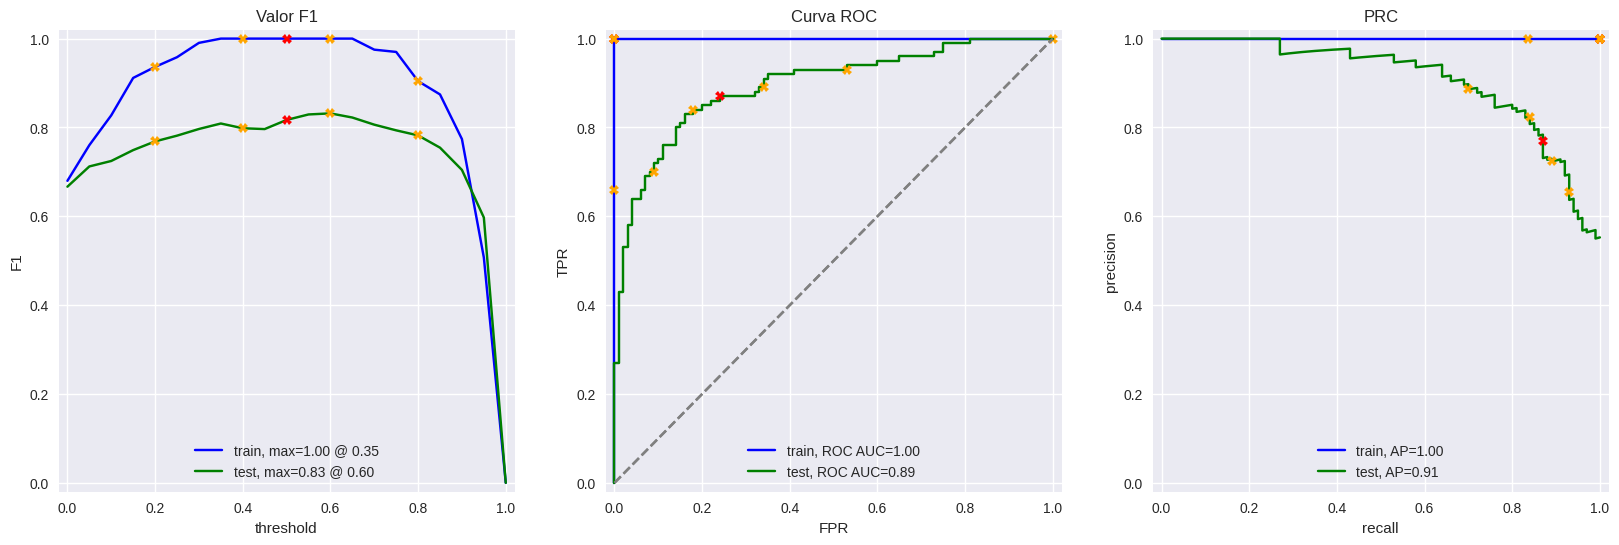

In [ ]:
evaluate_model(model_6, train_features_bert,  train_target_bert, test_features_bert, test_target_bert)

A la izquierda gráfica de valor F1 contra umbral, al centro las curvas ROC para el conjunto de entrenamiento y prueba. A la derecha curva PRC para el conjunto de entrenamiento y de prueba.

Se puede observar la mayor diferencia entre conjuntos de todos los modelos, lo cual indica un gran sobreajuste. Sin embargo esto es de esperar debido a que los conjuntos son de menor tamaño.

## Mis reseñas

En esta sección compararemos las predicciones realizadas con los modelos anteriores para las siguientes reseñas.

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

"\nmy_reviews = pd.DataFrame([\n    'Simplemente no me gustó, no es mi tipo de película.',\n    'Bueno, estaba aburrido y me quedé dormido a media película.',\n    'Estaba realmente fascinada con la película',    \n    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',\n    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',\n    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',\n    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',\n    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'\n], columns=['review'])\n"

Realizaremos los siguientes pasos de pre-procesamiento: normalización y lemmatización.

In [ ]:
my_reviews['review_norm'] = my_reviews['review'].apply(text_norm, pattern=r"[^a-zA-Z']")
my_reviews['lemmatized'] = my_reviews['review_norm'].apply(lemmatize)

Se crea el siguiente DataFrame para la comparación de resultados.

In [ ]:
models =[]
for i in range(1, 7):
    models.append('model_'+str(i))

In [ ]:
review_results = pd.DataFrame( columns=models, index=range(my_reviews.shape[0]))

### Modelo 1

In [ ]:
texts = my_reviews['review_norm']

review_results['model_1'] = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

### Modelo 2

In [ ]:
texts = my_reviews['lemmatized']

review_results['model_2'] = model_2.predict_proba(count_tf_idf_2.transform(texts))[:, 1]

### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

review_results['model_3'] = model_3.predict_proba(count_tf_idf_2.transform(texts))[:, 1]

### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

review_results['model_4'] = model_4.predict_proba(count_tf_idf.transform(texts))[:, 1]

### Modelo 5

In [ ]:
texts = my_reviews['review_norm']

review_results['model_5'] = model_5.predict_proba(count_tf_idf.transform(texts))[:, 1]

### Modelo 6

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_6 = BERT_text_to_embeddings(texts)

In [ ]:
review_results['model_6'] = model_6.predict_proba(my_reviews_features_6)[:, 1]

De acuerdo a la percepción personal, las valoraciones de las reseñas son:

In [ ]:
review_results['personal_assesment'] = [0,0,1,0,1,1,0,1]

Se muestran las predicciones para cada modelo.

In [ ]:
review_results

,model_1,model_2,model_3,model_4,model_5,model_6,personal_assesment
0,0.137346,0.167862,0.549402,0.578466,0.341667,NaN,0
1,0.158324,0.070634,0.282063,0.461997,0.304167,NaN,0
2,0.535050,0.507828,0.584500,0.593889,0.500000,NaN,1
3,0.111510,0.139106,0.584500,0.332313,0.270833,NaN,0
4,0.305875,0.231653,0.640498,0.644147,0.366667,NaN,1
5,0.470459,0.447750,0.562557,0.630076,0.425000,NaN,1
6,0.036507,0.025072,0.362718,0.219134,0.300000,NaN,0
7,0.822823,0.908165,0.749899,0.662289,0.637500,NaN,1


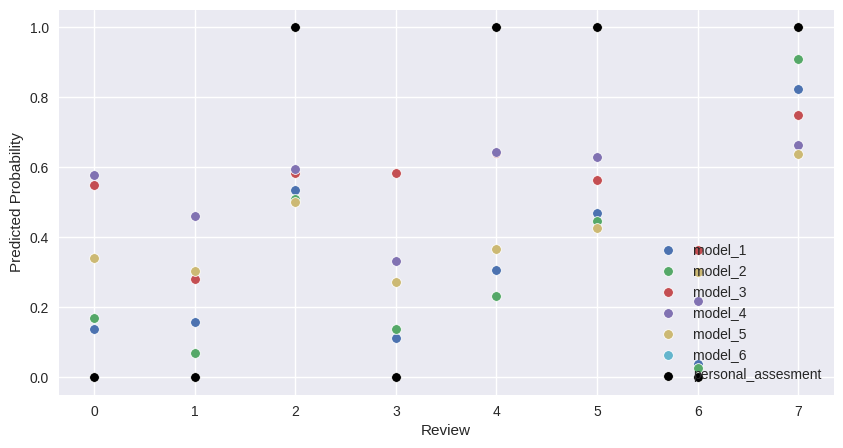

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

for i in range(1,7):
    sns.scatterplot(data=review_results, x=review_results.index, y=('model_'+str(i)), ax=ax)

sns.scatterplot(data=review_results, x=review_results.index, y='personal_assesment', color='black', ax=ax)

ax.set_xlabel('Review')
ax.set_ylabel('Predicted Probability')
ax.legend(review_results.columns, loc='lower right')

Probabilidades predichas por cada modelo para cada reseña. El modelo 6 muestra valoraciones más extremas, los modelos 3 y 5 tienden a predecir valores más cercanos al centro.

## Conclusiones

El objetivo del presente trabajo es encontrar un modelo de clasificación para reseñas de películas. Para lo cual se experimentó con tres tipos de clasificadores: Regresión Logística, Descenso de Gradiente y K Vecinos cercanos.

Por otro lado se utilizaron las librerías Nature Language Toolkit, spaCy  para encontrar palabras vacías. También se observa el efecto de realizar lemmatización. Para cada una de estas opciones se realiza una bolsa de palabras y vectorización con IF_IDF.

De todos los modelos se encontró que el de Regresión Logística con librería NLTK y sin lematización fue el que mejores resultados obtuvo, con un score f1 en el conjunto de prueba de 0.88. Este mismo modelo con la librería spaCy y con lemmatización no mejoró significativamente los resultados.

Por otro lado el clasificador con Descenso de Gradiente obtuvo las segundas mejores métricas, y estas probablemente pueden mejorar haciendo una búsqueda de hiperparámetros. Nuevamente la lematización no mejoró significativamente las métricas.

Para el clasificador de K Vecinos Cercanos se realizó una búsqueda de parámetros para el número de vecinos cercanos. Las predicciones para este modelo tuvieron menor exactitud, pero mostraron la mejor consistencia.

Por otro lado se explora la tokenización con BERT para un subconjunto de 200 reseñas aleaorioas de cada conjunto. Una vez obtenidos los insertados se entrenó un modelo de regresión logística. La exactitud de este modelo para el conjunto de prueba fue comparable al modelo de K Vecinos Cercanos. Sin embargo este modelo mostró el mayor sobreajuste.

Por último se realizó un análisis de reseñas adicionales utilizando los modelos anteriores. El modelo 6 muestra valoraciones más extremas mientras que los modelos 3 y 5 tienden a predecir valores más cercanos al centro.

El modelo con mejores métricas fue con Regresión Logística, con la librería NLTK sin lemmatización, con vectorización IF_IDF.

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones